In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#ml libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# preprocessing libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/cover.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)


In [3]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


## Data Cleaning

In [4]:
features_with_na = [column for column in df.columns if df[column].isna().sum() >= 1]
for column in features_with_na:
    print(column, np.round(df[column].isnull().sum()*100, 5), "% of missing feautes")

In [5]:
df.duplicated().sum()

0

In [8]:
numeric_features = [column for column in df.columns if df[column].dtype != 'O']
print("Number of numeric features:", len(numeric_features))

Number of numeric features: 55


In [9]:
categorical_features = [column for column in df.columns if df[column].dtype == 'O']
print("Number of categorical features:", len(categorical_features))

Number of categorical features: 0


In [14]:
discrete_features = [column for column in df.columns if df[column].nunique() <= 25]
print("Number of discrete feautres:", len(discrete_features))

Number of discrete feautres: 45


In [15]:
continous_features = [column for column in df.columns if df[column].nunique() > 25]
print("Number of continous feautres:", len(continous_features))

Number of continous feautres: 10


### Outliers

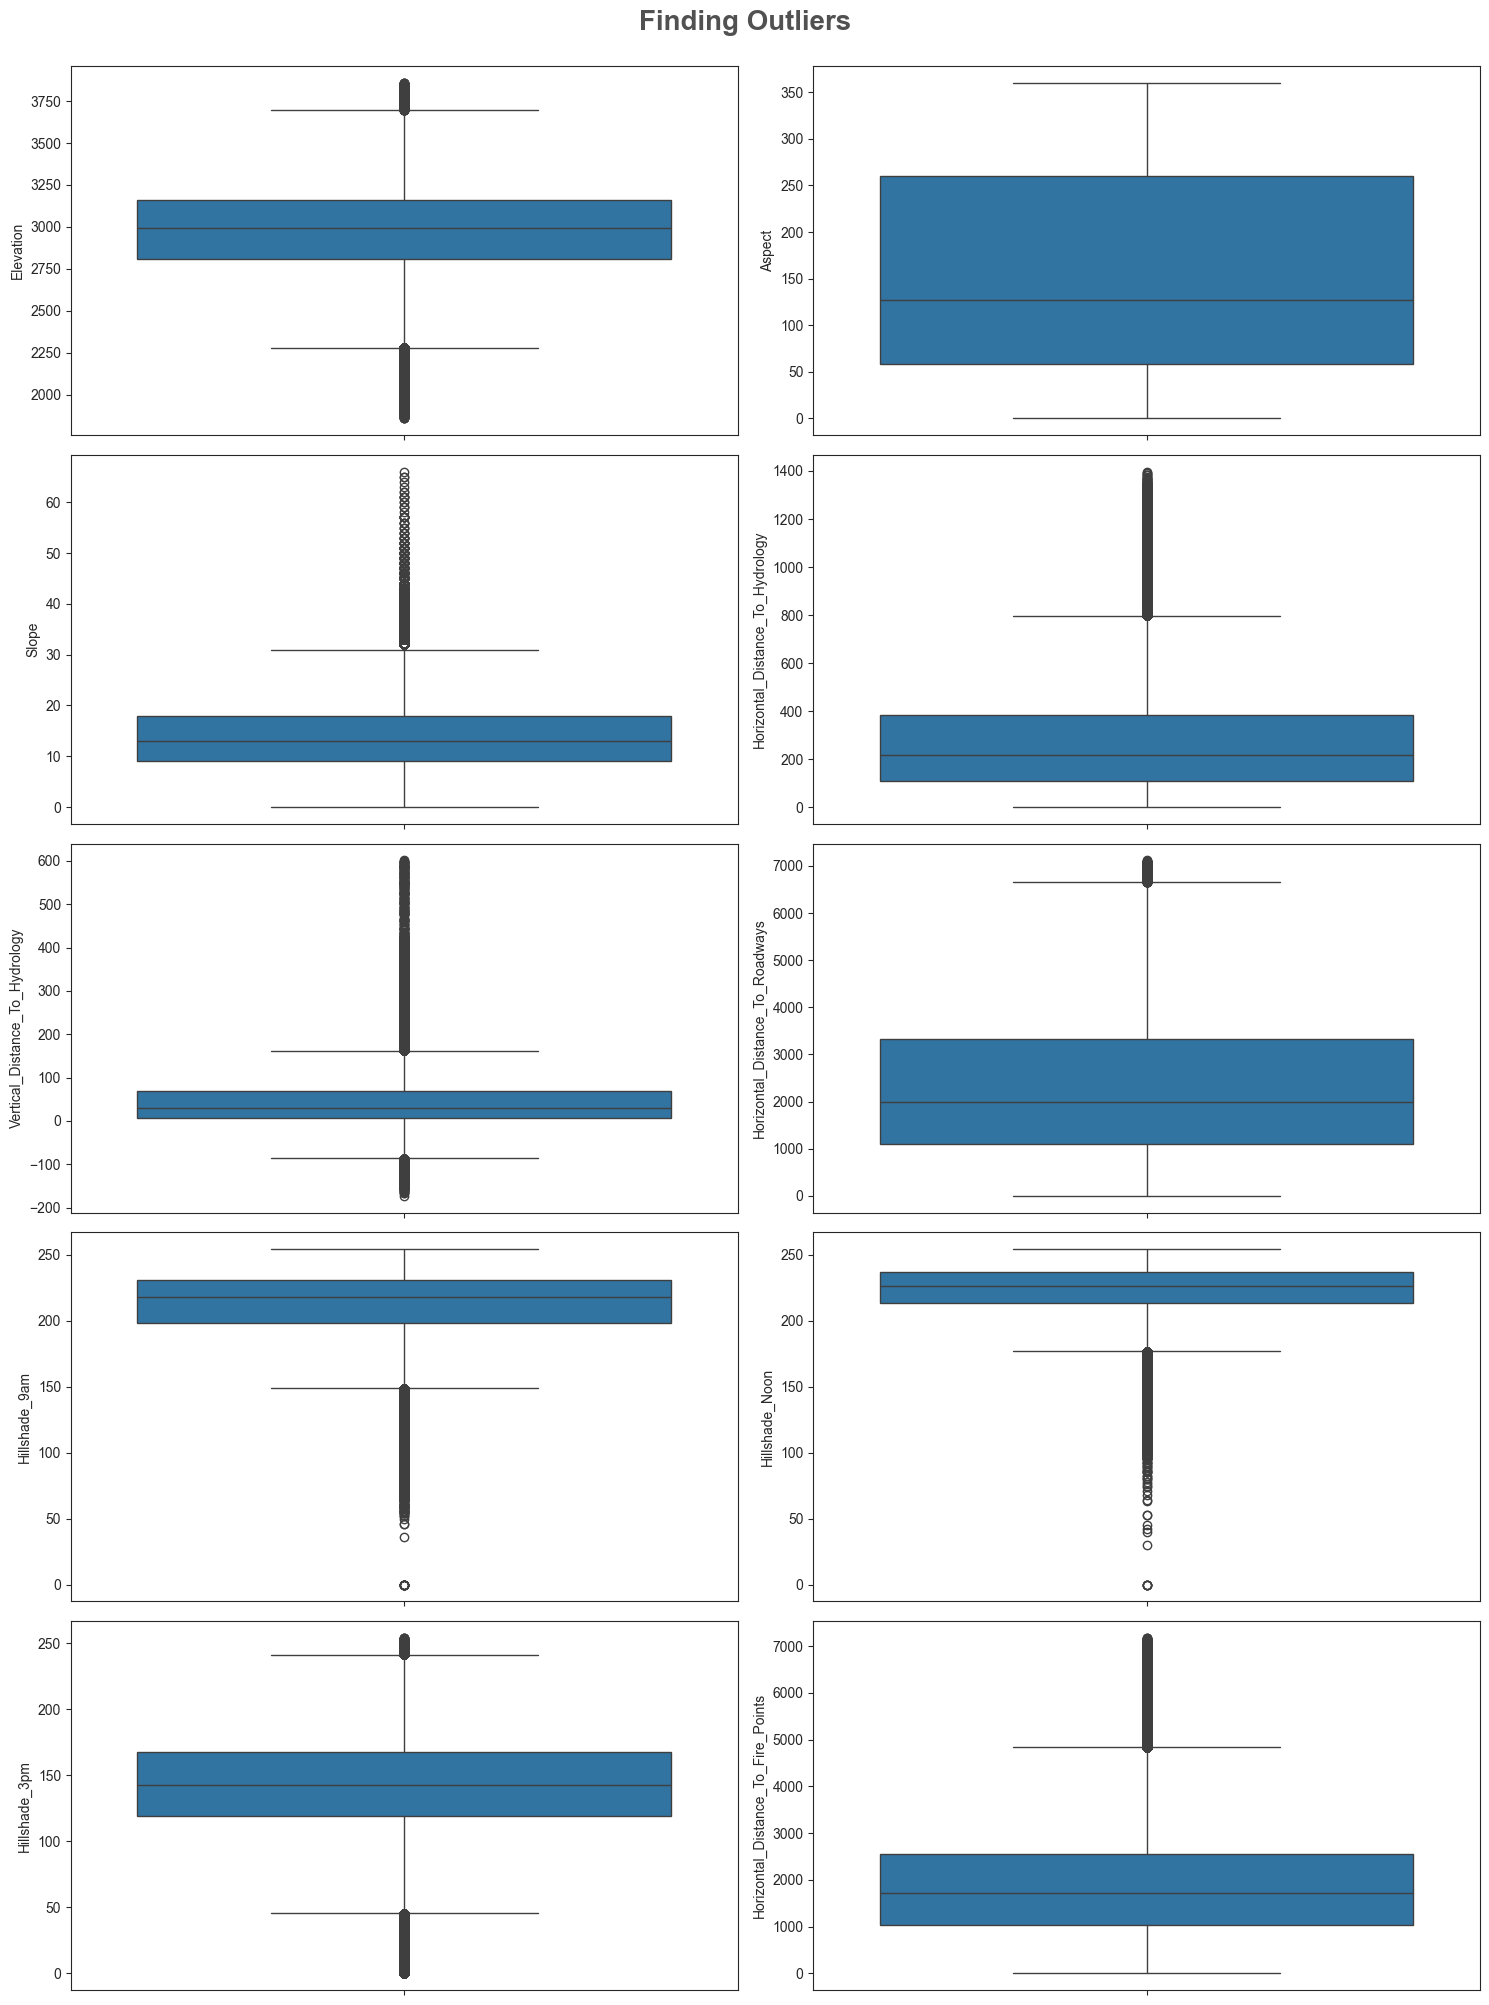

In [18]:
## Using IQR method and box plot

plt.figure(figsize=(15, 20))
plt.suptitle("Finding Outliers", fontsize=20, fontweight="bold", alpha=0.8, y=1.)
for idx, column in enumerate(continous_features):
    plt.subplot(5, 2, idx+1)
    sns.set_style("ticks")
    sns.boxplot(df[column])
    plt.tight_layout()


### Insights
* Apart from the feature *Aspect* everything else has outliers

In [27]:
df[continous_features].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [41]:
df_copy = df.copy()

def detect_and_cap_outliers(col, data=df_copy):
    percentile_25 = data[col].quantile(0.25)
    percentile_75 = data[col].quantile(0.75)
    iqr = percentile_75 - percentile_25
    upper_limit = percentile_75 + 1.5 * iqr
    lower_limit = percentile_25 - 1.5 * iqr
    data.loc[data[col] > upper_limit, col] = upper_limit
    data.loc[data[col] < lower_limit, col] = lower_limit
    return df_copy

In [42]:
for column in continous_features:
    df_copy = detect_and_cap_outliers(column)

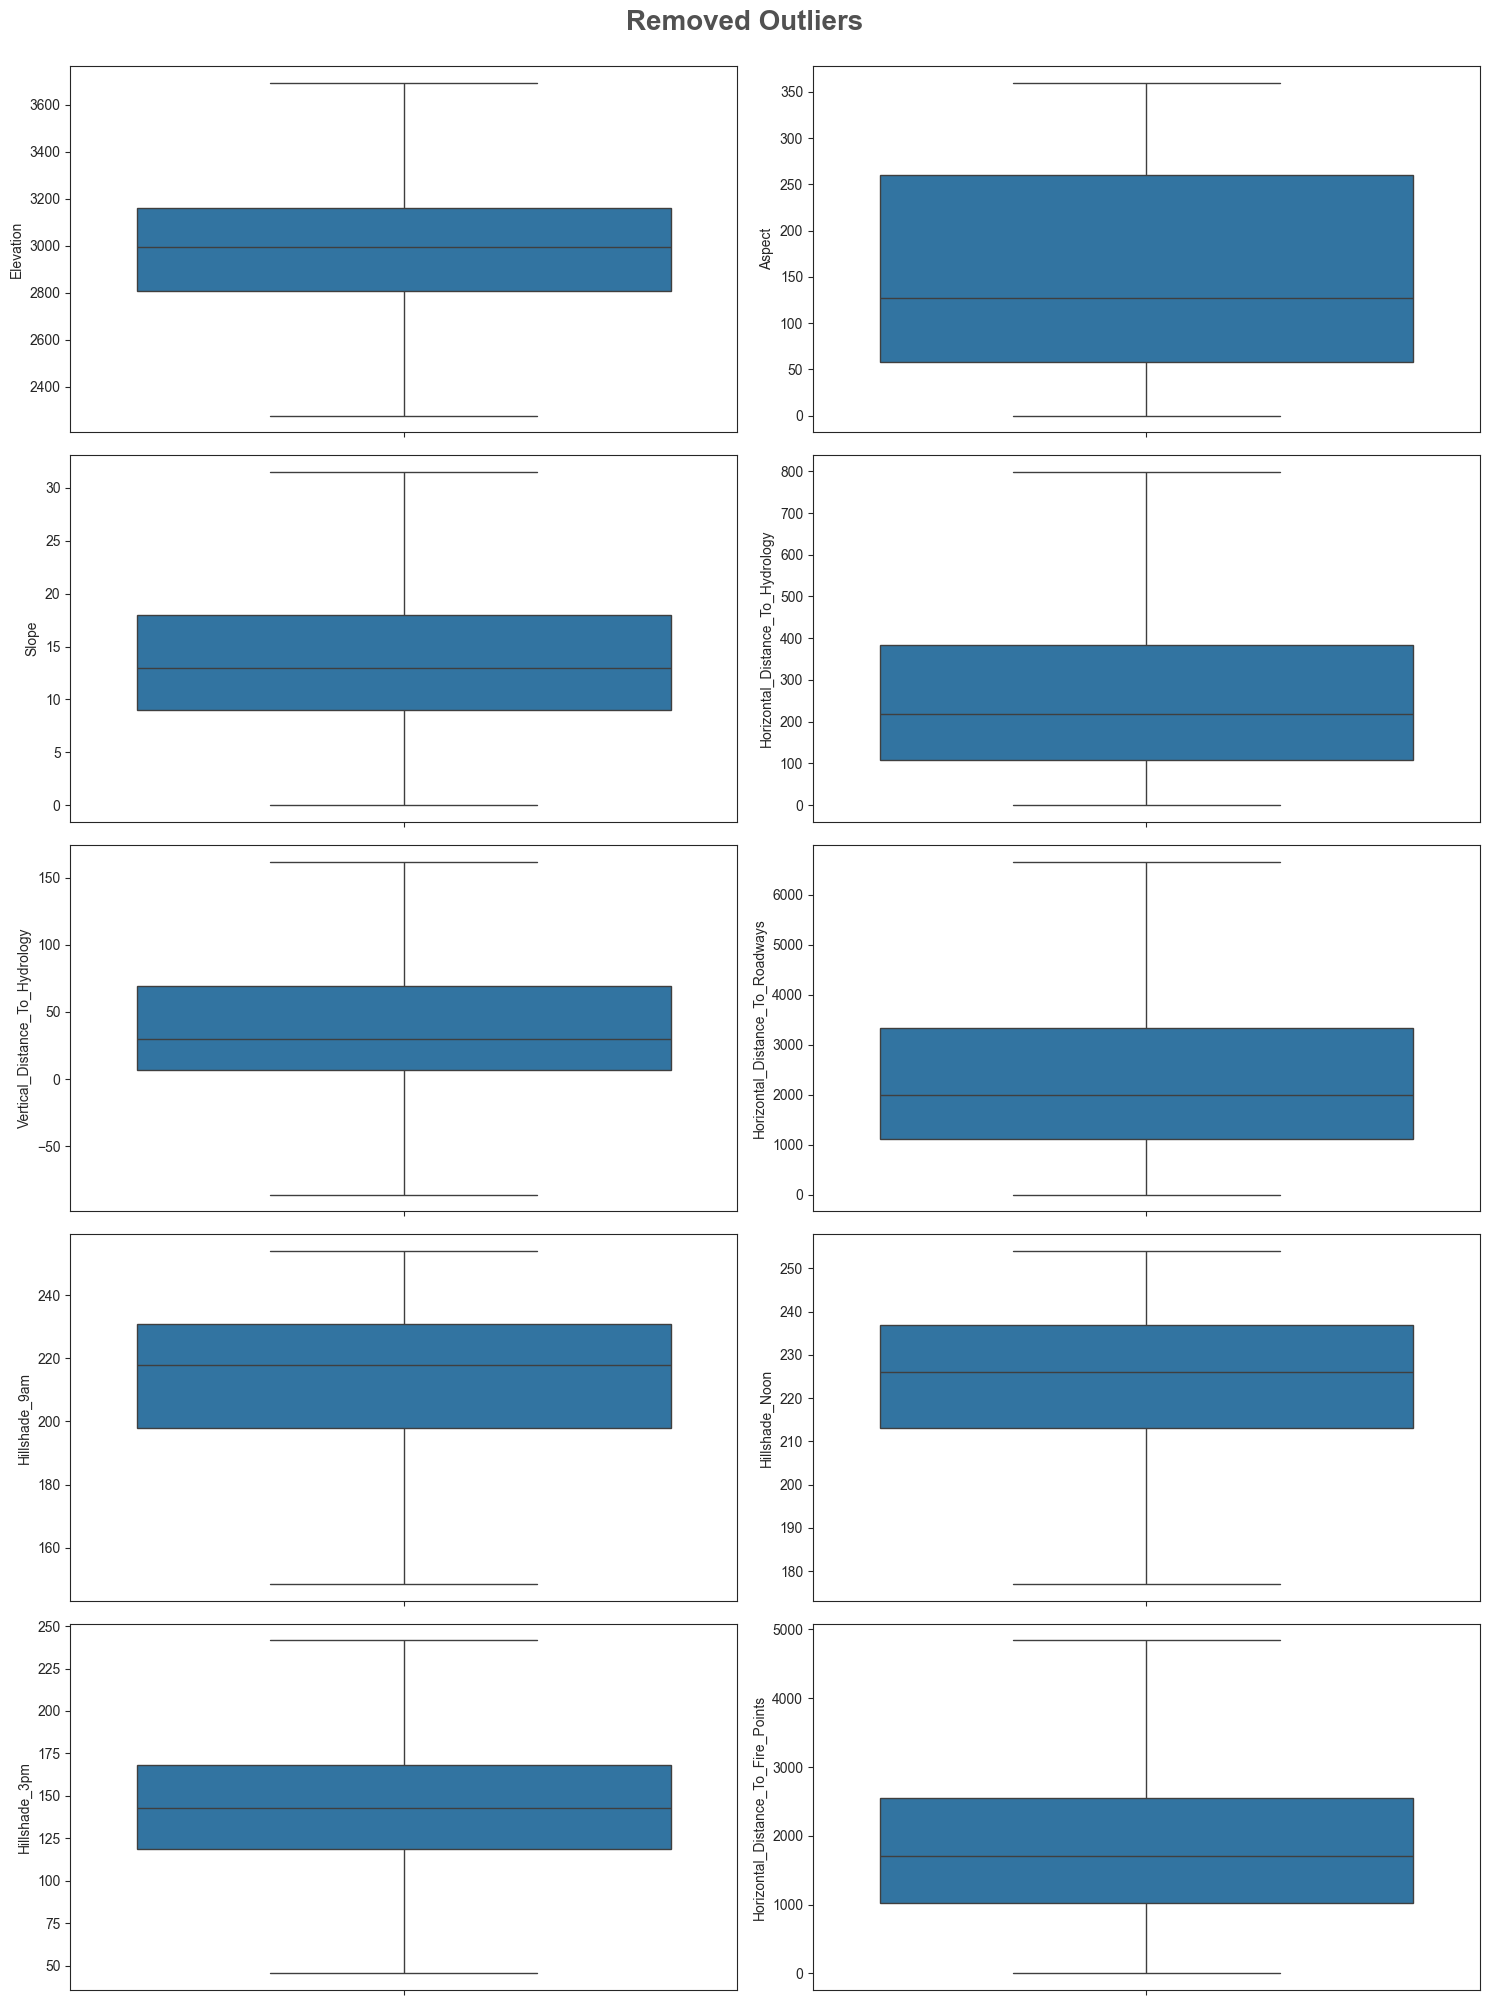

In [43]:
## Using IQR method and box plot

plt.figure(figsize=(15, 20))
plt.suptitle("Removed Outliers", fontsize=20, fontweight="bold", alpha=0.8, y=1.)
for idx, column in enumerate(continous_features):
    plt.subplot(5, 2, idx+1)
    sns.set_style("ticks")
    sns.boxplot(df_copy[column])
    plt.tight_layout()


#### Reduce columns for easy of work

In [48]:
df.iloc[:,10:14].columns

Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4'],
      dtype='object')

In [56]:
df_copy["Wilderness_Area_Type"] =(df.iloc[:,10:14] == 1).idxmax(1)

wilderness_types = sorted(df_copy["Wilderness_Area_Type"].unique())

In [57]:
wilderness_types

['Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4']

In [58]:
def split_numbers_chars(row):
    '''This function fetches the numerical characters at the end of a string
    returns alphabetical character and numerical charters respectively'''
    head = row.rstrip('0123456789')
    tail = row[len(head):]
    return head, tail

def reverse_one_hot_encode (dataframe, start_loc, end_loc, numeric_column_name):
    ''' this function takes the start and end location of the one-hot-encoded column set and numeric column name to be create
    1) transforms one-hot-encoded columns into one column consisting of column names with string data type
    2) splits string column into the alphabetical and numerical characters
    3) fetches numerical character and creates numeric column in the given dataframe
    '''

    dataframe['String Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1).idxmax(1)
    dataframe['Tuple Column'] = dataframe['String Column'].apply(split_numbers_chars)
    dataframe[numeric_column_name] = dataframe['Tuple Column'].apply(lambda x: x[1]).astype('int64')
    dataframe.drop(columns=['String Column', 'Tuple Column'], inplace=True)
    return dataframe

In [60]:
df_copy = reverse_one_hot_encode(df_copy,14, 54, "Soil_Type" )

In [63]:
df_copy.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

## Handling imbalance target

In [65]:
# change index to start from zero instead of 1
df_copy["Cover_Type"] = df_copy["Cover_Type"] - 1

In [67]:
df_copy["Cover_Type"].value_counts()

Cover_Type
1    283301
0    211840
2     35754
6     20510
5     17367
4      9493
3      2747
Name: count, dtype: int64

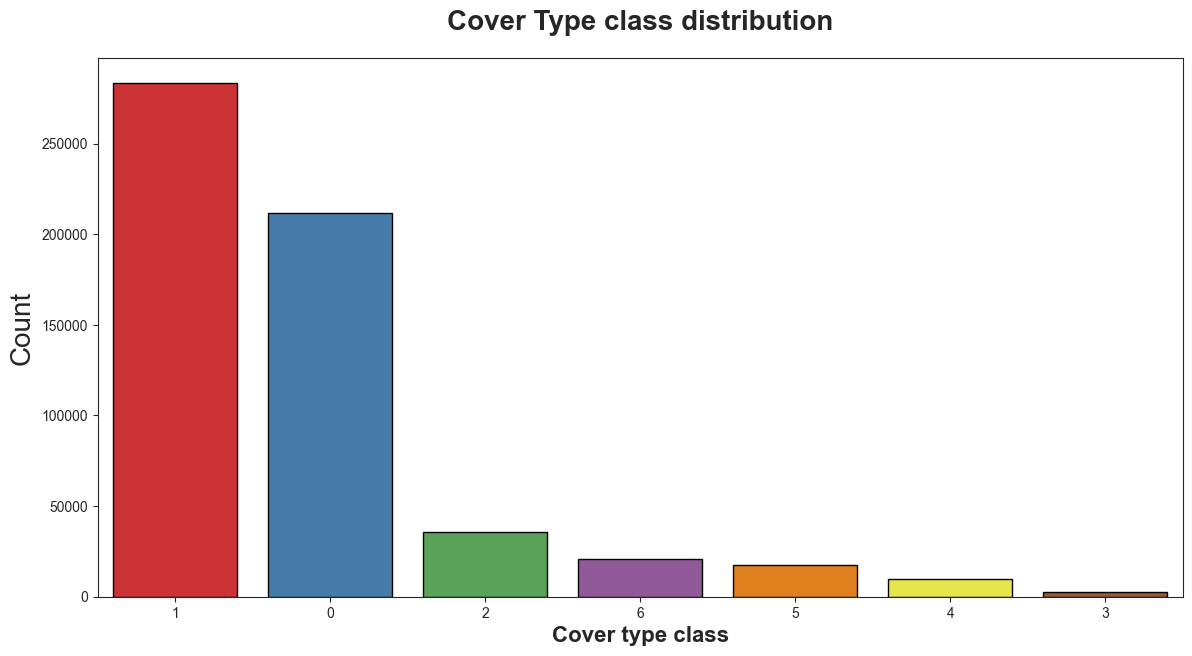

In [72]:
plt.subplots(figsize=(14, 7))
sns.countplot(data=df_copy, x="Cover_Type", palette="Set1", ec="black", order=df_copy["Cover_Type"].value_counts().index)
plt.title("Cover Type class distribution", weight="bold", pad=20, fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Cover type class", weight="bold", fontsize=16)
plt.show()

In [73]:
def split_and_scale(dataframe=df_copy):
    X = dataframe.drop(columns=["Cover_Type"])
    y = dataframe["Cover_Type"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # scaler
    scaler = StandardScaler()
    scaler.fit(X_train)


    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test



In [92]:
def evaluate_model(model, balanced_class, X_test, y_test):
    model_accuracy = model.score(X_test, y_test)

    print(f"Accracy {balanced_class}: {model_accuracy:.2f}")

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cl_report = classification_report(y_test, y_pred)

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt=".2f", vmin=0, cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.show()

    print("Classification Report:\n", cl_report)
    return model_accuracy


In [76]:
## Running with random forest

X_train, X_test, y_train, y_test = split_and_scale(df_copy.drop(columns=['Wilderness_Area_Type', 'Soil_Type']))

model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)

RandomForestClassifier()

Accracy Imbalanced: 0.95


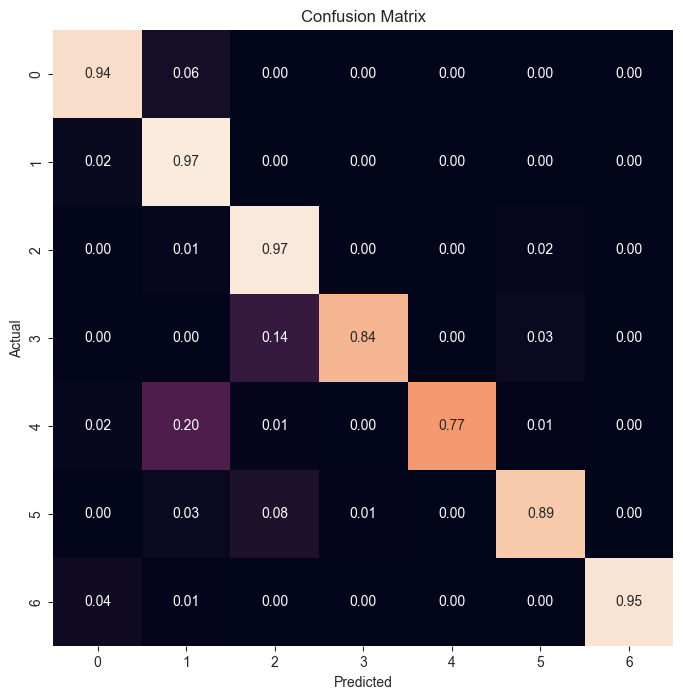

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     42557
           1       0.95      0.97      0.96     56500
           2       0.94      0.97      0.95      7121
           3       0.91      0.84      0.87       526
           4       0.94      0.77      0.85      1995
           5       0.93      0.89      0.91      3489
           6       0.97      0.95      0.96      4015

    accuracy                           0.95    116203
   macro avg       0.94      0.90      0.92    116203
weighted avg       0.95      0.95      0.95    116203



0.9536070497319347

In [93]:
evaluate_model(model_1, "Imbalanced", X_test, y_test)

In [90]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)

LogisticRegression()

Accracy Imbalanced: 0.72


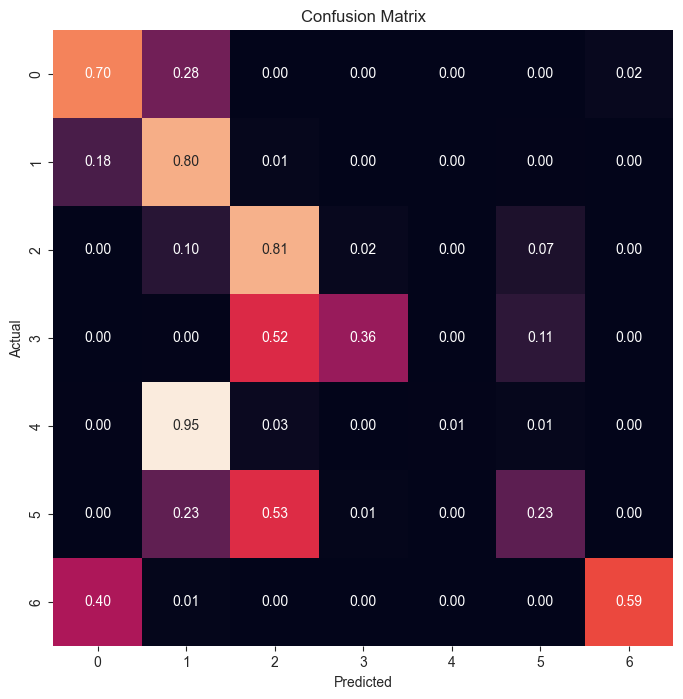

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71     42557
           1       0.75      0.80      0.77     56500
           2       0.67      0.81      0.73      7121
           3       0.54      0.36      0.43       526
           4       0.21      0.01      0.01      1995
           5       0.47      0.23      0.31      3489
           6       0.73      0.59      0.65      4015

    accuracy                           0.72    116203
   macro avg       0.58      0.50      0.52    116203
weighted avg       0.71      0.72      0.71    116203



0.7240776916258617

In [94]:
evaluate_model(model_2, "Imbalanced", X_test, y_test)

#### Inference
* the class with the most prediction difficulty is class 4.
* From above confusion matrix we can observe that most of the true positives and true negatives are from class 1 and Class 2 only.
* We have huge disconnection between over represented classes and under represented classes.

### 1. Random UnderSampling

removing data from the majoritiy class

In [97]:
under_sampled_df = df_copy.copy()
minimum_size_class = np.min(under_sampled_df["Cover_Type"].value_counts())
print("Size of the smallest sized class:", minimum_size_class)


Size of the smallest sized class: 2747


In [99]:
class_subsets = [under_sampled_df.query(f"Cover_Type == {str(i)}") for i in range(7)]
class_subsets[0]["Cover_Type"].unique()

array([0])

In [100]:
for i in range(7):
    class_subsets[i] = class_subsets[i].sample(minimum_size_class)
under_sampled_df = pd.concat(class_subsets, axis=0).sample(frac=1.0).reset_index(drop=True)

In [101]:
under_sampled_df["Cover_Type"].value_counts()

Cover_Type
6    2747
4    2747
3    2747
2    2747
5    2747
0    2747
1    2747
Name: count, dtype: int64

Accracy Under Sampled: 0.87


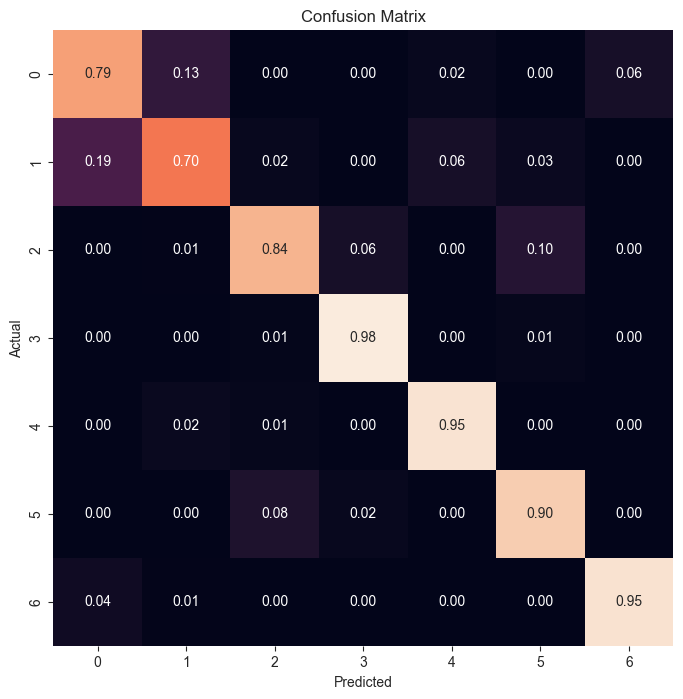

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.78       534
           1       0.81      0.70      0.75       557
           2       0.87      0.84      0.85       542
           3       0.93      0.98      0.95       564
           4       0.92      0.95      0.94       569
           5       0.86      0.90      0.88       536
           6       0.94      0.95      0.95       544

    accuracy                           0.87      3846
   macro avg       0.87      0.87      0.87      3846
weighted avg       0.87      0.87      0.87      3846



0.8723348933957358

In [103]:
X_train, X_test, y_train, y_test = split_and_scale(under_sampled_df.drop(columns=['Wilderness_Area_Type', 'Soil_Type']))

model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)
evaluate_model(model_1, "Under Sampled", X_test, y_test)

### 2. Random Over Sampling